In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchtext.data.utils import get_tokenizer
from torch.utils.data import Dataset, DataLoader
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split

In [55]:
data_df1 = pd.read_csv(r"/content/drive/MyDrive/Twitter_senti/reddit_twitter/Reddit_Data.csv",header=None)
data_df1 = data_df1.drop(data_df1.index[0]).reset_index(drop=True)
data_df2 = pd.read_csv(r"/content/drive/MyDrive/Twitter_senti/reddit_twitter/Twitter_Data.csv",header=None)
data_df2 = data_df2.drop(data_df2.index[0]).reset_index(drop=True)
data_df = pd.concat([data_df1, data_df2], ignore_index=True)
columns = list(data_df.columns)
columns[0], columns[1] = columns[1], columns[0]
data_df = data_df[columns]

In [56]:
data_df.head()

,1,0
0,1,family mormon have never tried explain them t...
1,1,buddhism has very much lot compatible with chr...
2,-1,seriously don say thing first all they won get...
3,0,what you have learned yours and only yours wha...
4,1,for your own benefit you may want read living ...


In [57]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

In [58]:
data_df.dropna(inplace = True)
data_df.drop_duplicates(inplace = True)
# data_df = data_df.drop(columns=data_df.columns[[0, 1]])
new_column_names = ['label', 'text']
data_df.columns = new_column_names
data_df = data_df.loc[data_df['label'] != 'Irrelevant'].copy()
data_df['label'] = label_encoder.fit_transform(data_df['label'])
print(len(data_df))

199708


In [59]:
data_df.head()

,label,text
0,2,family mormon have never tried explain them t...
1,2,buddhism has very much lot compatible with chr...
2,0,seriously don say thing first all they won get...
3,1,what you have learned yours and only yours wha...
4,2,for your own benefit you may want read living ...


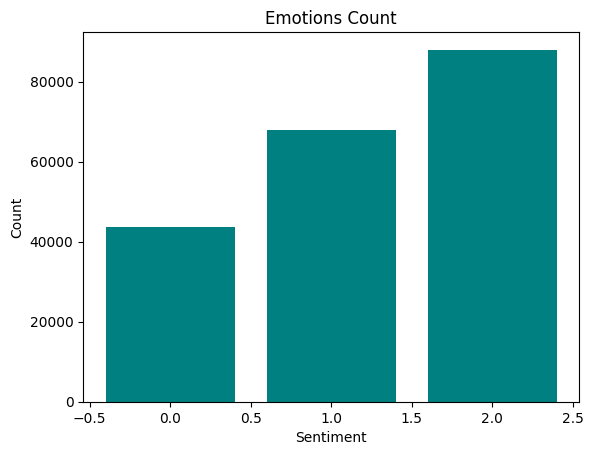

[87992, 67961, 43755]


In [60]:
data_df.head()

emotions_count = data_df['label'].value_counts()
plt.bar(list(emotions_count.keys()), list(emotions_count), color='teal')
plt.xlabel("Sentiment",)
plt.ylabel('Count')
plt.title('Emotions Count')
plt.show()
print(list(emotions_count))

In [61]:
nltk.download('stopwords')
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def clean_text(text, stem=True):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return text



tokenizer = get_tokenizer('basic_english')
train_data = data_df['text'].apply(clean_text).apply(tokenizer)
data_df['tokens'] = train_data
print(data_df['tokens'][:4])
print(data_df['label'][:4])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    [family, mormon, have, never, tried, explain, ...
1    [buddhism, has, very, much, lot, compatible, w...
2    [seriously, don, say, thing, first, all, they,...
3    [what, you, have, learned, yours, and, only, y...
Name: tokens, dtype: object
0    2
1    2
2    0
3    1
Name: label, dtype: int64


In [62]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data_df, test_size=0.2, shuffle=True, random_state = 123)
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

label
2    70485
1    54278
0    35003
Name: count, dtype: int64
label
2    17507
1    13683
0     8752
Name: count, dtype: int64


In [63]:
def build_vocab(texts):
        all_tokens = [token for text in texts for token in text]
        vocab = {token: idx for idx, token in enumerate(set(all_tokens))}
        vocab['<pad>'] = len(vocab)
        print(f"Vocabulary Length is: {len(vocab)}")
        return vocab, len(vocab)

vocab, VOCAB_SIZE = build_vocab(train_data)

Vocabulary Length is: 123992


In [64]:
BATCH_SIZE = 32
HIDDEN_DIM = 256
MAX_LEN = 50
EMBED_DIM = 128
pad_index = vocab["<pad>"]

In [65]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, max_len = MAX_LEN, pad_token = '<pad>'):
        self.texts = texts
        self.pad_token = pad_token
        self.max_length = max_len
        self.labels = labels
        self.vocab = vocab

    def text_to_tensor(self, text):
        text_indices = [self.vocab.get(token) for token in text]

        if len(text_indices) < self.max_length:
            text_indices = text_indices + [self.vocab[self.pad_token]] * (self.max_length - len(text_indices))
        else:
            text_indices = text_indices[:self.max_length]
        return torch.tensor(text_indices, dtype=torch.long)

    def label_to_tensor(self, label):
        return torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return self.text_to_tensor(text), self.label_to_tensor(label)

train_dataset = TextDataset(train_df['tokens'].tolist(), train_df['label'].tolist(), vocab = vocab)
test_dataset = TextDataset(test_df['tokens'].tolist(), test_df['label'].tolist(), vocab = vocab)

for text_tensor, label_tensor in test_dataset:
    print(f"text_tensor: {text_tensor}")
    print(f"label_tensor: {label_tensor}")
    tokenized_tensor = text_tensor
    break


text_tensor: tensor([ 20617,  87112,  84452,  53892,  11493,  96315,  43215,  14876,  80360,
         16554,  75203, 101402, 104218,  76188,  21041,  21831,  13466,  20617,
        119822,   7533,  92205,  58671,   8155, 108018,  44868, 107685, 108964,
         82890,  75203, 101402, 100056,  78144,  97220, 104218,  20617, 120585,
         76188,  21041,  21831,  13466,   2320, 119822,   7533,  92205,  20617,
        117941, 108233,  87112,  84452,  53892])
label_tensor: 2


In [66]:
reverse_vocab = {v: k for k, v in vocab.items()}

# Function to convert tensor to sentence
def tensor_to_sentence(tensor):
    tokens = [reverse_vocab[idx.item()] for idx in tensor if idx.item() in reverse_vocab]
    return ' '.join(tokens)

print(tensor_to_sentence(tokenized_tensor))

bjp shatrughan sinha has asked his party some pointed questions day when modi amit shah and several bjp mps are fasting protest against washout parliament budget session part day when prime minister narendra modi bjp president amit shah and several nda mps are fasting bjp patna sahib shatrughan sinha has


In [67]:
device = ('cuda'
          if torch.cuda.is_available()
          else "mps"
          if torch.backends.mps.is_available()
          else "cpu"
          )


print(f"Using Device: {device}")

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

n = 0
for X, Y in test_dataloader:
    n+=1
    if n > 5:
        break
    else:
        print(f"Shape of X: {tensor_to_sentence(X[0])}")
        print(f"Shape of Y: {Y[0]}")

Using Device: cpu
Shape of X: bjp shatrughan sinha has asked his party some pointed questions day when modi amit shah and several bjp mps are fasting protest against washout parliament budget session part day when prime minister narendra modi bjp president amit shah and several nda mps are fasting bjp patna sahib shatrughan sinha has
Shape of Y: 2
Shape of X: does this address hon prime minister narendra modi for election campaign <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: 1
Shape of X: but bcs modi using chowkidaar just win election such incapable leader have never seen anywhere the world <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Sh

In [68]:
class GRUModel(nn.Module):
    def __init__(self):
            super().__init__()
            self.embedding = nn.Embedding(VOCAB_SIZE, EMBED_DIM)
            self.gru = nn.GRU(EMBED_DIM, HIDDEN_DIM, dropout=0.3, batch_first=True)
            self.fc = nn.Linear(HIDDEN_DIM, 3)
            self.dropout = nn.Dropout(0.3)
            self.sigmoid = nn.Sigmoid()
            self.no_layers = 1



    def forward(self, x, hidden):
            batch_size = x.size(0)
            embedded = self.embedding(x)
            output, hidden = self.gru(embedded)
            output = self.dropout(output[:, -1])
            output = self.fc(output)


            return output, hidden

    def init_hidden(self, batch_size):

        h0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,HIDDEN_DIM)).to(device)
        hidden = (h0,c0)
        return hidden

In [69]:
gru_model = GRUModel().to(device)
print(gru_model)

GRUModel(
  (embedding): Embedding(123992, 128)
  (gru): GRU(128, 256, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (sigmoid): Sigmoid()
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [70]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = gru_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = gru_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[1])}")
    print(f"Shape of Y: {Y.shape}")
    print(f"pred shape: {pred.shape}")
    break

Shape of X: answer what are your views rahul gandhi recent tweet mocking modi wishing him world theatre day <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Shape of Y: torch.Size([32])
pred shape: torch.Size([32, 3])


In [71]:
loss_func_gru = torch.nn.CrossEntropyLoss().to(device)
optimizer_gru = torch.optim.Adam(gru_model.parameters(), lr=1e-3)

In [72]:
def get_accuracy(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label).item()

In [73]:
CLIP = 1

def train(dataloader, model, loss_fn, optimizer, train_losses):
    size = len(dataloader.dataset)
    model.train()
    h = model.init_hidden(BATCH_SIZE)
    loss_sum = 0
    accuracy = 0
    num_batches = len(dataloader)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        h = tuple([each.data for each in h])
        pred, h = model(x, h)
        loss = loss_fn(pred, y)
        loss_sum += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()
        optimizer.zero_grad()
        accuracy += get_accuracy(pred, y)
        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

    mean_loss = loss_sum / num_batches
    accuracy /= size
    train_losses.append(mean_loss)
    print(f"Training loss: {mean_loss:>7f}")
    print(f"Training accuracy: {(accuracy*100):>7f}")



In [74]:
def test(dataloader, model, loss_fn, test_losses):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, accuracy = 0, 0
    h = model.init_hidden(BATCH_SIZE)
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            h = tuple([each.data for each in h])
            pred, h = model(x, h)
            test_loss += loss_fn(pred, y).item()
            accuracy += get_accuracy(pred, y)
    test_loss /= num_batches
    accuracy /= size
    print("________")
    print(f"Test loss: {test_loss:>7f}")
    print(f"Test accuracy: {(accuracy*100):>0.1f}%")
    test_losses.append(test_loss)

In [75]:
train_losses = []
test_losses = []

for i in range(10):
    print(f'Epoch {i} -----------------------------------')
    train(train_dataloader, gru_model, loss_func_gru, optimizer_gru, train_losses)
    test(test_dataloader, gru_model, loss_func_gru, test_losses)

print('Finished Training')

Epoch 0 -----------------------------------
loss: 1.122044 [   32/159766]
loss: 0.887574 [ 6432/159766]
loss: 0.761573 [12832/159766]
loss: 0.704691 [19232/159766]
loss: 0.578170 [25632/159766]
loss: 0.223867 [32032/159766]
loss: 0.422232 [38432/159766]
loss: 0.457740 [44832/159766]
loss: 0.572415 [51232/159766]
loss: 0.589303 [57632/159766]
loss: 0.362221 [64032/159766]
loss: 0.372980 [70432/159766]
loss: 0.396329 [76832/159766]
loss: 0.315705 [83232/159766]
loss: 0.180795 [89632/159766]
loss: 0.180149 [96032/159766]
loss: 0.417532 [102432/159766]
loss: 0.475836 [108832/159766]
loss: 0.383047 [115232/159766]
loss: 0.181662 [121632/159766]
loss: 0.435395 [128032/159766]
loss: 0.145336 [134432/159766]
loss: 0.143403 [140832/159766]
loss: 0.179993 [147232/159766]
loss: 0.073557 [153632/159766]
Training loss: 0.392813
Training accuracy: 85.304132
________
Test loss: 0.196897
Test accuracy: 94.0%
Epoch 1 -----------------------------------
loss: 0.135465 [   32/159766]
loss: 0.040710 [ 643

In [76]:
print(train_losses)


[0.3928126535165198, 0.14164731342229084, 0.0832586631181374, 0.05395289269082933, 0.03716531890155891, 0.027728057717248577, 0.02220162978940192, 0.01935862949776678, 0.01775908328083869, 0.01754869385711723]


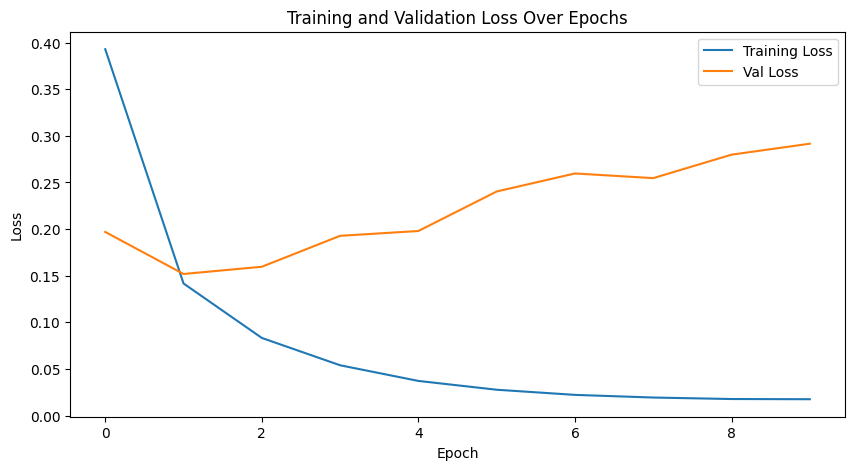

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [78]:
for X, Y in test_dataloader:
    X = X.to(device)
    Y = Y.to(device)
    h = gru_model.init_hidden(BATCH_SIZE)
    h = tuple([each.data for each in h])
    pred, h = gru_model(X, h)
    print(f"Shape of X: {tensor_to_sentence(X[10])}")
    print(f"Shape of Y: {Y[10]}")
    print(f"pred shape: {pred[10]}")
    x = X
    y = Y
    break

Shape of X: isn the whole debate centered around the effects the said crops your health just the anti vaccine crowd diversifying also monsanto who keeps patenting everything and prevents farmers under threat litigation reuse seeds from last year wouldn this affect indian farmers who are mostly poor <pad> <pad> <pad> <pad> <pad>
Shape of Y: 0
pred shape: tensor([-3.4664, -1.9061,  4.8733], grad_fn=<SelectBackward0>)


tensor([2, 1, 1, 0, 0, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0,
        2, 0, 2, 1, 1, 1, 0, 2])
tensor([1, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0,
        2, 0, 2, 1, 1, 1, 0, 2])


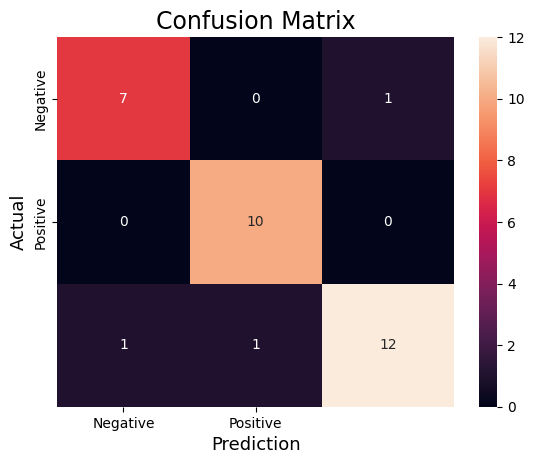

In [79]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix on 1 batch in the validation set

h = gru_model.init_hidden(BATCH_SIZE)
h = tuple([each.data for each in h])
predicted, h = gru_model(x, h)
print(y)
print(predicted.argmax(1))
y = y.cpu().detach().numpy()
cm = confusion_matrix(y, predicted.argmax(1).cpu().detach().numpy())
sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Prediction',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()